Group Members: Asha Karmakar, Akhil Iyer, Megan Sundheim, Grace Kim
Asha -
Grace -
Akhil - 
Megan - 

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import random
from sklearn import metrics

<p> https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features </p>

<h1> Data Preprocessing & Exploration </h1>

In [2]:
# Read in csv file
df = pd.read_csv("./data/genres.csv")

/var/folders/pg/jgps72r91276npng3bqr2zg40000gn/T/ipykernel_1155/3599437126.py:2: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./data/genres.csv")


In [3]:
# Clean data
# Remove the following columns: type, id, uri, track_href, analysis_url, unnamed, title, song_name
df = df[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'genre']]

In [4]:
# one hot encode time signature
df = pd.get_dummies(df, columns=['time_signature'], drop_first=False)

print (df)
print(df.shape)

       danceability  energy  key  loudness  mode  speechiness  acousticness  \
0             0.831   0.814    2    -7.364     1       0.4200      0.059800   
1             0.719   0.493    8    -7.230     1       0.0794      0.401000   
2             0.850   0.893    5    -4.783     1       0.0623      0.013800   
3             0.476   0.781    0    -4.710     1       0.1030      0.023700   
4             0.798   0.624    2    -7.668     1       0.2930      0.217000   
...             ...     ...  ...       ...   ...          ...           ...   
42300         0.528   0.693    4    -5.148     1       0.0304      0.031500   
42301         0.517   0.768    0    -7.922     0       0.0479      0.022500   
42302         0.361   0.821    8    -3.102     1       0.0505      0.026000   
42303         0.477   0.921    6    -4.777     0       0.0392      0.000551   
42304         0.529   0.945    9    -5.862     1       0.0615      0.001890   

       instrumentalness  liveness  valence    tempo

In [5]:
# Separate data into features and class labels
print(df.columns.get_loc('genre'))
features = pd.concat([df.iloc[:, :12], df.iloc[:, 13:]], axis=1)
labels = df.iloc[:, 12]
# .values.ravel()

12


In [6]:
# print (labels)
label_groups = df.groupby('genre')
print(len(label_groups.size()))

print (label_groups.size())

15
genre
Dark Trap          4578
Emo                1680
Hiphop             3028
Pop                 461
Rap                1848
RnB                2099
Trap Metal         1956
Underground Rap    5875
dnb                2966
hardstyle          2936
psytrance          2961
techhouse          2975
techno             2956
trance             2999
trap               2987
dtype: int64


In [7]:
# There are no missing values:
null_data = df[df.isnull().any(axis=1)]
len(null_data)

0

[Text(0.5, 0, 'danceability'),
 Text(1.5, 0, 'energy'),
 Text(2.5, 0, 'key'),
 Text(3.5, 0, 'loudness'),
 Text(4.5, 0, 'mode'),
 Text(5.5, 0, 'speechiness'),
 Text(6.5, 0, 'acousticness'),
 Text(7.5, 0, 'instrumentalness'),
 Text(8.5, 0, 'liveness'),
 Text(9.5, 0, 'valence'),
 Text(10.5, 0, 'tempo'),
 Text(11.5, 0, 'duration_ms'),
 Text(12.5, 0, 'time_signature_1'),
 Text(13.5, 0, 'time_signature_3'),
 Text(14.5, 0, 'time_signature_4'),
 Text(15.5, 0, 'time_signature_5')]

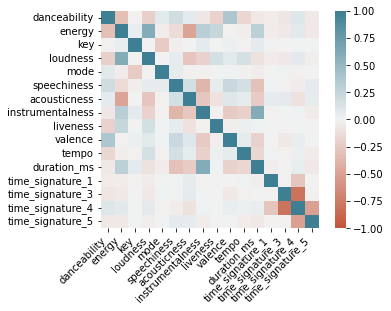

In [8]:
import seaborn as sns

# correlation between features

ax = sns.heatmap(
    features.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

In [9]:
# Perform Anomaly Detection
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

y_pred_list = []

envelope_pred = EllipticEnvelope().fit_predict(features)
y_pred_list.append(envelope_pred)

# apply IsolationForest AD
forest_pred = IsolationForest().fit_predict(features)
y_pred_list.append(forest_pred)

# apply LocalOutlierFactor AD
lof_pred = LocalOutlierFactor().fit_predict(features)
y_pred_list.append(lof_pred)

y_pred_list

[array([ 1, -1,  1, ...,  1,  1,  1]),
 array([ 1,  1, -1, ...,  1,  1,  1]),
 array([1, 1, 1, ..., 1, 1, 1])]

In [10]:
from collections import Counter

for arr in y_pred_list:
    c = Counter(arr)
    print(c)

Counter({1: 38074, -1: 4231})
Counter({1: 38154, -1: 4151})
Counter({1: 40473, -1: 1832})


In [11]:
# Need to standardize for PCA.
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaled_data = StandardScaler().fit_transform(features.values)
music_data_scaled = pd.DataFrame(scaled_data, columns=features.columns)
music_data_scaled.head()

print("num features before PCA: ", len(features.columns))

# your code goes here
pca = PCA(n_components=0.95, svd_solver='full')
pca_data = pca.fit_transform(music_data_scaled)
music_data_pca = pd.DataFrame(pca_data)
music_data_pca.head()

print("num features after PCA: ", len(music_data_pca.columns))

num features before PCA:  16
num features after PCA:  13


In [12]:
# Perform decision tree classification before PCA and then perform another decision tree after PCA

import sklearn.model_selection as ms

x_train, x_test, y_train, y_test = ms.train_test_split(features, labels, test_size=0.2)

print("Number of records in training set:", len(x_train.index))
print("Number of records in test set:", len(x_test.index))

Number of records in training set: 33844
Number of records in test set: 8461


<h1> Model Building </h1>

<h1> Performing a KNN Classification on the Full Dataset </h1>

In [52]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

param_grid = {
    'pca__n_components': list(range(10, 16)),
    'knn__n_neighbors': list(range(5, 20)),
    'knn__weights': ['uniform', 'distance'],
}


knn_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()), ('knn', KNeighborsClassifier())])

knn_gscv = GridSearchCV(estimator=knn_pipe, param_grid=param_grid, scoring='accuracy', cv=5)

knn_gscv.fit(features, labels)

print("KNN GridSearchCV Best Params: ", knn_gscv.best_params_)
print("KNN GridSearchCV Best Score", knn_gscv.best_score_)

KNN GridSearchCV Best Params:  {'knn__n_neighbors': 17, 'knn__weights': 'distance', 'pca__n_components': 15}
KNN GridSearchCV Best Score 0.5756057203640232


In [53]:
knn_accs = ms.cross_val_score(knn_gscv, features, labels, cv=5, scoring='accuracy')

print("Accuracy of KNN Classifier: ", np.average(knn_accs))
print()

knn_pred = ms.cross_val_predict(knn_gscv, features, labels, cv=5)
knn_report = metrics.classification_report(y_true=labels, y_pred=knn_pred)

print("KNN Classifier Report")
print(knn_report)

Accuracy of KNN Classifier:  0.5721309537879684



<h1> Analyzing the Full Dataset through K-Means Clustering </h1>

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import MDS

kmeans = KMeans(n_clusters=15)
kpred = kmeans.fit_predict(music_data_pca)
sil_score = silhouette_score(music_data_pca, kpred, metric='euclidean')

print("Silhouette score for K-Means Clustering with k = 15", sil_score)


Silhouette score for K-Means Clustering with k = 15 0.14560401418214428


In [15]:
import numpy as np
import pandas as pd   

""" Usage: pandas_entropy(df['column1']) """

# Based on StackOverflow post: https://stackoverflow.com/questions/49685591/how-to-find-the-entropy-of-each-column-of-data-set-by-python
def pandas_gini(column):
    vc = pd.Series(column).value_counts(sort=False)
    return 1 - (np.square((vc / len(column)))).sum()

entropies = []
cluster_labels = []
cluster_names = []

for k in range(0, 15):

    filtered_cluster = labels[kpred == k]

    lbl = filtered_cluster.value_counts(sort=False).argmax()
    genre_cf = filtered_cluster.mode()
    
    cluster_labels.append(lbl)
    cluster_names.append(genre_cf.values[0])

    entropies.append(pandas_gini(filtered_cluster))

print(cluster_names)
print(cluster_labels)
print (entropies)

['techhouse', 'hardstyle', 'Underground Rap', 'Dark Trap', 'Dark Trap', 'Hiphop', 'Underground Rap', 'techno', 'techno', 'Dark Trap', 'psytrance', 'Dark Trap', 'Dark Trap', 'dnb', 'trap']
[8, 14, 1, 0, 0, 7, 1, 8, 8, 0, 11, 0, 0, 13, 11]
[0.846054112479904, 0.8210308337492898, 0.7052975000591034, 0.8552614819303616, 0.9001003391071501, 0.7730241155278506, 0.8583908868610962, 0.8017432245306164, 0.7470300859470355, 0.8652444444444445, 0.8733010070407051, 0.8048073975221366, 0.8322027755244004, 0.8606761486934356, 0.7950815139327779]


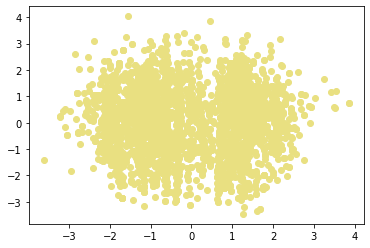

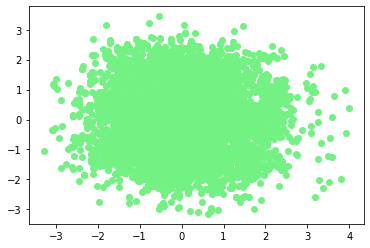

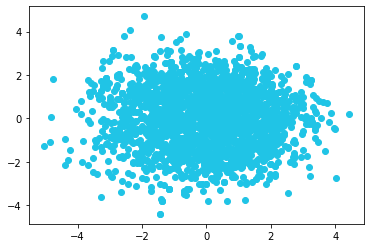

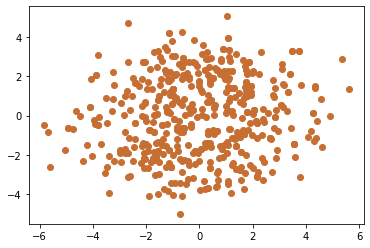

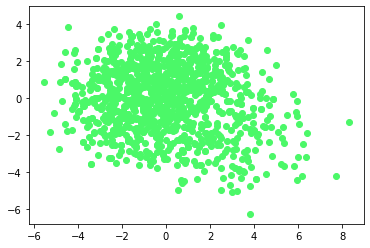

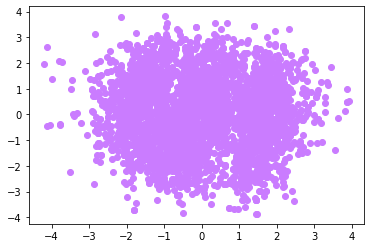

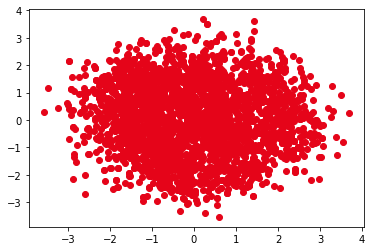

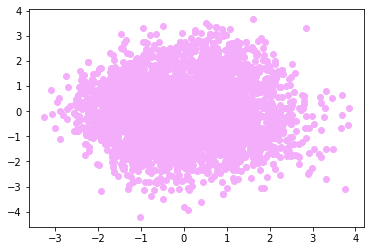

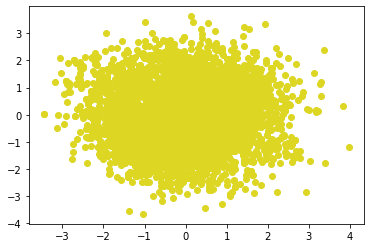

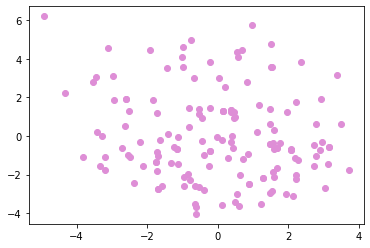

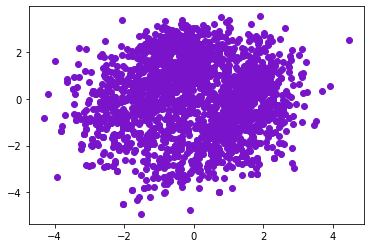

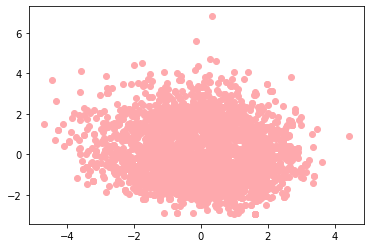

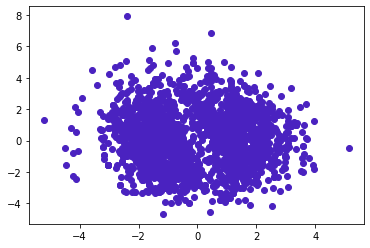

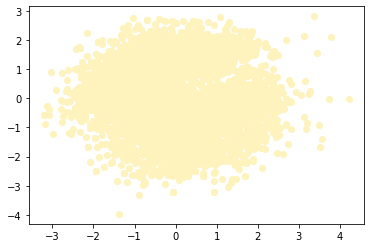

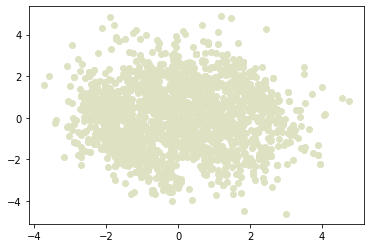

In [16]:

colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(15)]

for k in range(0, 15):

    filtered_label0 = music_data_pca[kpred == k]

    mds = MDS(n_components=3)
    mds_data = mds.fit_transform(filtered_label0)
    plt.scatter(mds_data[:,0] , mds_data[:,1], c=colors[k])
    plt.show()

plt.show()

<h1>Determining a Hierarchy Among the Centroids For the Full Dataset</h1>

In [17]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet

centers = kmeans.cluster_centers_

def find_best_hier_params(centers):
    proximity_matrix = pdist(centers)
    methods = ['single', 'complete', 'average', 'centroid', 'ward']
    cpccs = []
    # the rest of your code goes here

    # Compute correlation for every linkage method and get the method with highest corr
    for method in methods:
        link_matrix = linkage(centers, method)
        cpcc, _ = cophenet(link_matrix, proximity_matrix)
        cpccs.append(cpcc)

    print ("The ", methods[np.argmax(cpccs)], "method worked best since it had the highest CPCC of", np.amax(cpccs))
    
    return methods[np.argmax(cpccs)]

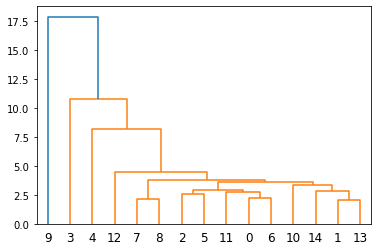

In [18]:
hier = linkage(centers, 'average')
plt.figure()
dn = dendrogram(hier)
plt.show()

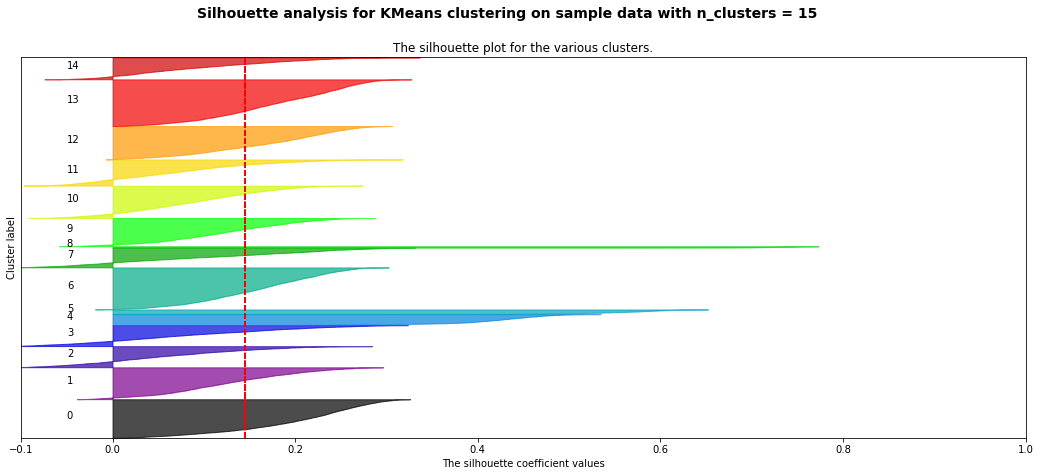

In [19]:
# Code adapted from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

def silhouette_plot(music_data_pca, n_clusters=15):
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])

    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(music_data_pca) + (n_clusters + 1) * 10])

    cur_kpred = KMeans(n_clusters=n_clusters).fit_predict(music_data_pca)

    avg_sil_score = silhouette_score(music_data_pca, cur_kpred, metric='euclidean')
    sample_silhouette_values = silhouette_samples(music_data_pca, cur_kpred)

    y_lower = 10
    for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cur_kpred == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=avg_sil_score, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        plt.suptitle(
            "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
            % n_clusters,
            fontsize=14,
            fontweight="bold",
        )

    plt.show()

silhouette_plot(music_data_pca, n_clusters=15)

In [20]:
kmeans_sil_scores = []
for i in range(2, 16):
    ith_kmeans = KMeans(n_clusters=i)
    ith_kpred = ith_kmeans.fit_predict(music_data_pca)
    ith_sil_score = silhouette_score(music_data_pca, ith_kpred, metric='euclidean')
    kmeans_sil_scores.append(ith_sil_score)

print ("Best K for K-Means Clustering: ", np.argmax(kmeans_sil_scores) + 2)
print ("Highest silhouette score", np.amax(kmeans_sil_scores))

Best K for K-Means Clustering:  3
Highest silhouette score 0.16759399872312453


<h1>Creating a Custom Supervised Clustering Algorithm using KMeans and KNN for the Full Dataset</h1>

In [29]:
def kmeans_per_label(music_data_pca, labels, clusters_per_label=5):

    pca_df = pd.concat([pd.DataFrame(music_data_pca), pd.DataFrame(labels).reset_index(drop=True)], axis=1)

    group_labels = pca_df.groupby('genre')
    all_genres = pca_df['genre'].unique()

    all_centroids = []
    centroid_labels = []

    for genre in all_genres:
        cur_group = group_labels.get_group(genre)

        group_data = cur_group.drop('genre', axis=1)
        cur_kmeans = KMeans(n_clusters=clusters_per_label)
        cur_kmeans.fit_predict(group_data)
        
        for centroid in cur_kmeans.cluster_centers_:
            all_centroids.append(centroid)
            centroid_labels.append(genre)

    return (all_centroids, centroid_labels)

The  average method worked best since it had the highest CPCC of 0.9951822012407706


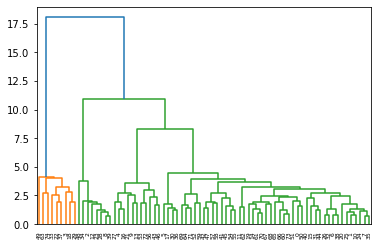

In [36]:
all_centroids, _ = kmeans_per_label(music_data_pca, labels, 5)
hier2 = linkage(all_centroids, find_best_hier_params(all_centroids))
plt.figure()
dn2 = dendrogram(hier2)
plt.show()

In [38]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier

class KCentroidsClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, clusters_per_label=5, n_neighbors=5, *,
                 weights='uniform', algorithm='auto', leaf_size=30,
                 p=2, metric='minkowski', metric_params=None, n_jobs=None,
                 **kwargs):
        
        self.centroids_ = None
        self.classes_ = None
        self.clusters_per_label = clusters_per_label
        self.weights = weights
        self.leaf_size = leaf_size
        self.p = p
        self.metric = metric
        self.metric_params = metric_params
        self.n_jobs = n_jobs
        self.algorithm = algorithm
        self.n_neighbors = n_neighbors
        self.knn_ = KNeighborsClassifier(n_neighbors=n_neighbors,
                 weights=weights, algorithm=algorithm, leaf_size=leaf_size,
                 p=2, metric=metric, metric_params=metric_params, n_jobs=n_jobs,
                 **kwargs)
        
    def fit(self, X, y):
        self.centroids_, self.classes_ = kmeans_per_label(X, y, self.clusters_per_label)
        self.knn_.fit(self.centroids_, self.classes_)
        return self
    
    def predict(self, X):
        kpred = self.knn_.predict(X)
        return kpred
    
    def predict_proba(self, X):
        return self.knn_.predict_proba(X)

In [31]:
kcc = KCentroidsClassifier(clusters_per_label=5, n_neighbors=1)
kcc.fit(music_data_pca, labels)

kcc_pred = kcc.predict(music_data_pca)
print (metrics.accuracy_score(labels, kcc_pred))

42305
0.4737028720009455


In [51]:
from sklearn.pipeline import Pipeline

kcc_param_grid = {
    'pca__n_components': list(range(5, 16)),
    'kcc__n_neighbors': list(range(1, 10)),
    'kcc__weights': ['uniform', 'distance'],
    'kcc__clusters_per_label': list(range(1, 5))
}


kcc_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.95, svd_solver='full')), ('kcc', KCentroidsClassifier(clusters_per_label=5, n_neighbors=10, weights='distance'))])

pipe_pred = ms.cross_val_score(kcc_pipe, features, labels, cv=5, scoring='accuracy')

print(np.average(pipe_pred))

0.4296182484339913


In [ ]:
from sklearn.model_selection import GridSearchCV

kcc_param_grid = {
    'pca__n_components': list(range(11, 16)),
    'kcc__n_neighbors': list(range(1, 5)),
    'kcc__weights': ['uniform', 'distance'],
    'kcc__clusters_per_label': list(range(1, 6))
}

kcc_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()), ('kcc', KCentroidsClassifier())])

kcc_gscv = GridSearchCV(estimator=kcc_pipe, param_grid=kcc_param_grid, scoring='accuracy', cv=5)

kcc_gscv.fit(features, labels)

print("KCentroidsClassifier GridSearchCV Best Params: ", kcc_gscv.best_params_)
print("KCentroidsClassifier GridSearchCV Best Score", kcc_gscv.best_score_)

KNN GridSearchCV Best Params:  {'kcc__clusters_per_label': 4, 'kcc__n_neighbors': 9, 'kcc__weights': 'distance', 'pca__n_components': 14}
KNN GridSearchCV Best Score 0.38049875901193714


In [ ]:
kcc_accs = ms.cross_val_score(kcc_gscv, features, labels, cv=5, scoring='accuracy')

print("Accuracy of KCentroidsClassifier: ", np.average(kcc_accs))

kcc_pred = ms.cross_val_predict(kcc_gscv, features, labels, cv=5)
kcc_report = metrics.classification_report(y_true=labels, y_pred=kcc_pred)

print("KCC Classifier Report")
print(kcc_report)